In [ ]:
!cp /content/drive/MyDrive/Colab\ Notebooks/include/data_utils.py /content/
#TODO: remove the below 'prerequisites' after cleaning up data_utils
!cp /content/drive/MyDrive/Colab\ Notebooks/include/tuning_utils.py /content/
!cp /content/drive/MyDrive/Colab\ Notebooks/include/models.py /content/
!cp /content/drive/MyDrive/Colab\ Notebooks/include/sca_utils.py /content/
!cp /content/drive/MyDrive/Colab\ Notebooks/include/data_utils.py /content/
!pip install keras-tuner --upgrade

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 129.1/129.1 kB 11.8 MB/s eta 0:00:00


RUN_DIR: /content/drive/MyDrive/mbedtls_synthetic_traces/RANDOM_training/runs_CBAMB2_CBAM_20250910_214501
Missing: []
VK-val preds shape: (5000, 256)  VK-val labels shape: (5000,)
[Calibration] Fitted temperature on VK-val: T = 217.7953
Dataset created from 'byte_2.h5':
  - Total samples: 25001
  - Training samples: 0
  - Validation samples: 25001


/usr/local/lib/python3.12/dist-packages/keras/src/trainers/epoch_iterator.py:160: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self._interrupted_warning()


Attack traces: 25001


Trials: 100%|██████████| 10/10 [04:27<00:00, 26.73s/it]


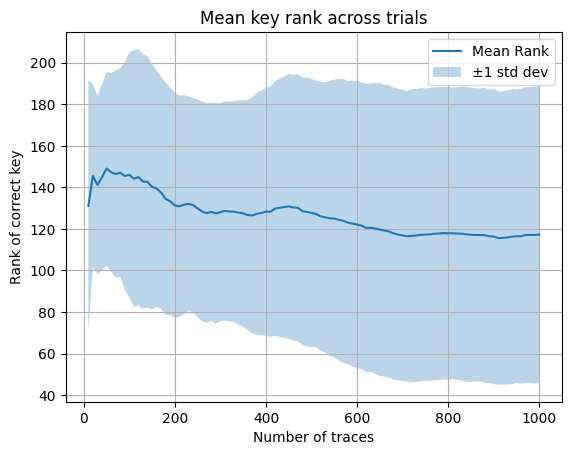

Saved (no T): /content/drive/MyDrive/mbedtls_synthetic_traces/RANDOM_training/runs_CBAMB2_CBAM_20250910_214501/rank_attack_noT_b2_CBAM.png


Trials: 100%|██████████| 10/10 [04:28<00:00, 26.81s/it]


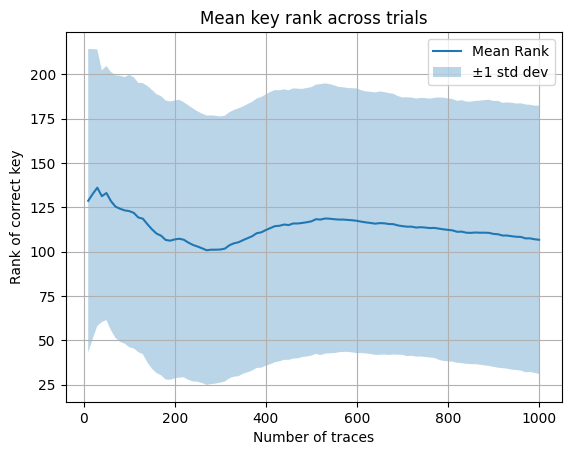

Saved (with T): /content/drive/MyDrive/mbedtls_synthetic_traces/RANDOM_training/runs_CBAMB2_CBAM_20250910_214501/rank_attack_withT_b2_CBAM.png

[Diagnostics]
VK logits (min,max,mean): -27.631021 0.0 -19.01696
ATT logits (min,max,mean): -27.631021 0.0 -19.109423
looks_like_prob(VK preds): True
looks_like_prob(ATT preds): True


<Figure size 640x480 with 0 Axes>

In [ ]:
# =========================
# EVAL: VK-calibrate -> FK-attack (robust to probs/logits)
# =========================

# ----- CONFIG -----
BYTE = 2
MODEL = "CBAM" # or "SE"
RUN_DIR = "/content/drive/MyDrive/mbedtls_synthetic_traces/RANDOM_training/runs_CBAMB2_CBAM_20250910_214501"

# --- Imports ---
import os, numpy as np, tensorflow as tf, matplotlib.pyplot as plt
from data_utils import SyntheticDataLoader
from sca_utils import run_rank_trials, plot_mean_rank

try:
    from models import ChannelwisePool
    CUSTOMS = {"ChannelwisePool": ChannelwisePool}
except Exception:
    CUSTOMS = {}

# --- Sanity: required artifacts from training (VK) ---
need = ["best.keras", "val_logits_labels.npz"]
missing = [f for f in need if not os.path.exists(os.path.join(RUN_DIR, f))]
print("RUN_DIR:", RUN_DIR)
print("Missing:", missing)
assert not missing, f"Missing files in {RUN_DIR}: {missing}"

# --- Load model and VK-val preds/labels ---
model = tf.keras.models.load_model(os.path.join(RUN_DIR, "best.keras"), compile=False, custom_objects=CUSTOMS)
vk_npz = np.load(os.path.join(RUN_DIR, "val_logits_labels.npz"))
vk_pred = vk_npz["logits"] # NOTE: could be *probabilities* if head=softmax, or logits if head=None
vk_lab = vk_npz["labels"] # VK-val labels for *the same target byte*

print("VK-val preds shape:", vk_pred.shape, " VK-val labels shape:", vk_lab.shape)

# --- Helper: numerically stable softmax ---
def softmax_stable(z):
    z = z - np.max(z, axis=1, keepdims=True)
    e = np.exp(z)
    return e / np.sum(e, axis=1, keepdims=True)

# --- Detect if preds look like probabilities or logits ---
def looks_like_prob(P, atol=1e-4):
    row_sums = np.sum(P, axis=1)
    return np.all(np.isfinite(P)) and np.all(P >= -1e-8) and np.all(P <= 1+1e-8) and np.allclose(row_sums, 1.0, atol=atol)

def to_logits(pred):
    """Convert model output to logits:
       - if already logits: return as-is
       - if probabilities: return log(prob) (logit-like)"""
    eps = 1e-12
    if looks_like_prob(pred):
        return np.log(np.clip(pred, eps, 1.0))
    else:
        return pred

# --- Fit temperature on VK-val ONLY (NLL minimization) ---
def fit_temperature(z_val, y_val, steps=60, growth=1.4):
    # simple 1D search around current T
    T = 1.0
    def nll(t):
        P = softmax_stable(z_val / t)
        return -np.mean(np.log(np.clip(P[np.arange(len(y_val)), y_val], 1e-12, 1.0)))
    for _ in range(steps):
        cands = [T / growth, T, T * growth]
        vals = [nll(t) for t in cands]
        T = cands[int(np.argmin(vals))]
    return T

# --- Step 1: compute VK logits (from preds) and fit T ---
z_val = to_logits(vk_pred)
T = fit_temperature(z_val, vk_lab, steps=60, growth=1.4)
print(f"[Calibration] Fitted temperature on VK-val: T = {T:.4f}")

# --- Step 2: load FK attack data and predict ---
H5_ATTK = f"/content/drive/MyDrive/mbedtls_synthetic_traces/RANDOM_datasets/attack_windows/byte_{BYTE}.h5"
att_loader = SyntheticDataLoader(H5_ATTK)
_, ds_att_full, _, _, _ = att_loader.create_dataset(window_index=0, batch_size=256, val_split=1.0)

# Predict on attack
ds_att_X = ds_att_full.map(lambda trace, label, pt, key: trace)
att_pred = model.predict(ds_att_X, verbose=0) # could be probs or logits depending on head

# --- Step 3: build meta (FK), careful with scalar key/plaintext ---
meta = []
for _, _, pt, key in ds_att_full.unbatch():
    k16 = np.zeros(16, np.uint8); k16[BYTE] = key.numpy() if key.shape==() else key.numpy()[BYTE]
    p16 = np.zeros(16, np.uint8); p16[BYTE] = pt.numpy() if pt.shape==() else pt.numpy()[BYTE]
    meta.append({"plaintext": p16, "key": k16})
N_att = len(meta)
print("Attack traces:", N_att)

In [ ]:
# --- Step 4: Evaluate WITHOUT temperature (baseline) ---
if looks_like_prob(att_pred):
    P_noT = att_pred
else:
    P_noT = softmax_stable(att_pred) # logits -> probs baseline

steps0, ranks0 = run_rank_trials(
    P_noT, meta,
    n_traces_per_trial=min(1000, N_att),
    n_trials=10, target_byte=BYTE
)
plot_mean_rank(steps0, ranks0)
fig0 = os.path.join(RUN_DIR, f"rank_attack_noT_b{BYTE}_{MODEL}.png")
plt.savefig(fig0, dpi=200, bbox_inches='tight')
print("Saved (no T):", fig0)

# --- Step 5: Evaluate WITH temperature ---
z_att = to_logits(att_pred)
P_T = softmax_stable(z_att / T)

stepsT, ranksT = run_rank_trials(
    P_T, meta,
    n_traces_per_trial=min(1000, N_att),
    n_trials=10, target_byte=BYTE
)
plot_mean_rank(stepsT, ranksT)
figT = os.path.join(RUN_DIR, f"rank_attack_withT_b{BYTE}_{MODEL}.png")
plt.savefig(figT, dpi=200, bbox_inches='tight')
print("Saved (with T):", figT)

# --- Diagnostics ---
print("\n[Diagnostics]")
print("VK logits (min,max,mean):", np.min(z_val), np.max(z_val), np.mean(z_val))
print("ATT logits (min,max,mean):", np.min(z_att), np.max(z_att), np.mean(z_att))
print("looks_like_prob(VK preds):", looks_like_prob(vk_pred))
print("looks_like_prob(ATT preds):", looks_like_prob(att_pred))

In [ ]:
# PATCH rank()
def rank(predictions, metadata, real_key, traces_idxs, last_key_bytes_proba, target_byte):
    if len(last_key_bytes_proba) == 0:
        key_bytes_proba = np.zeros(256)
    else:
        key_bytes_proba = last_key_bytes_proba

    for t_idx in traces_idxs:
        pt = metadata[t_idx]['plaintext'][target_byte]
        for key_guess in range(256):
            label_idx = SBOX[pt ^ key_guess]
            p = predictions[t_idx][label_idx]
            key_bytes_proba[key_guess] += np.log(max(p, 1e-12))  # avoid log(0)

    # correct key byte
    correct_key = metadata[t_idx]['key'][target_byte]
    sorted_idx = np.argsort(key_bytes_proba)[::-1]
    real_key_rank = np.where(sorted_idx == correct_key)[0][0]
    return real_key_rank, key_bytes_proba

Collected: (2501, 701, 1) (2501,)
10/10 ━━━━━━━━━━━━━━━━━━━━ 9s 816ms/step
prof_pred shape: (2501, 256)
[Profiling sanity] Classification accuracy = 0.0040


Trials: 100%|██████████| 5/5 [08:46<00:00, 105.29s/it]


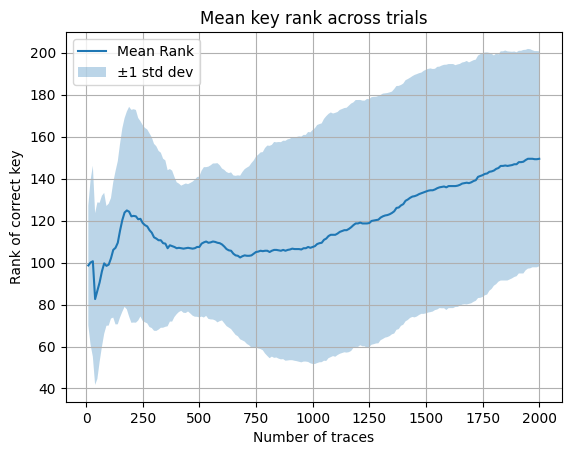

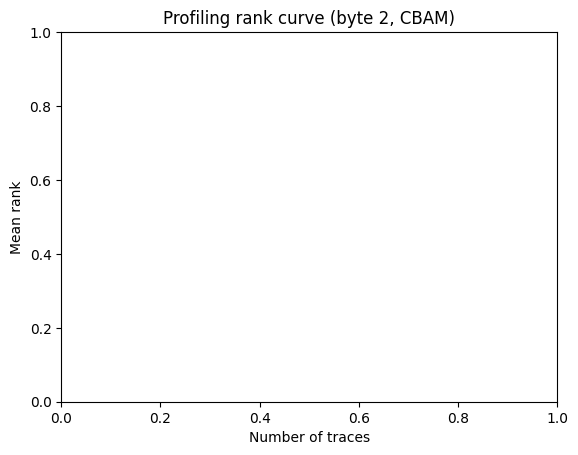

In [ ]:
import numpy as np, matplotlib.pyplot as plt, os, tensorflow as tf
from sca_utils import run_rank_trials, plot_mean_rank

# --- Config ---
BYTE = 2
MODEL = "CBAM"
RUN_DIR = "/content/drive/MyDrive/mbedtls_synthetic_traces/RANDOM_training/runs_CBAMB2_CBAM_20250910_214501"
H5_PROF = f"/content/drive/MyDrive/mbedtls_synthetic_traces/RANDOM_datasets/attack_windows/byte_{BYTE}.h5"

# --- Load model ---
from models import ChannelwisePool
model = tf.keras.models.load_model(
    os.path.join(RUN_DIR, "best.keras"),
    compile=False,
    custom_objects={"ChannelwisePool": ChannelwisePool}
)

# --- Collect ALL profiling traces/labels/meta via generator ---
from data_utils import SyntheticDataLoader
prof_loader = SyntheticDataLoader(H5_PROF)

traces, labels, pts, keys = [], [], [], []
for trace, label, pt, key in prof_loader.data_generator(window_index=0):
    traces.append(trace)
    labels.append(label)
    pts.append(pt)
    keys.append(key)

X_np = np.stack(traces)   # shape: (N, trace_len, 1)
y_np = np.array(labels)   # true class indices (0..255)
pts  = np.array(pts)
keys = np.array(keys)

print("Collected:", X_np.shape, y_np.shape)

# --- Run model predictions ---
prof_pred = model.predict(X_np, batch_size=256, verbose=1)
print("prof_pred shape:", prof_pred.shape)

# --- Sanity: classification accuracy ---
pred_classes = np.argmax(prof_pred, axis=1)
acc = np.mean(pred_classes == y_np)
print(f"[Profiling sanity] Classification accuracy = {acc:.4f}")

# --- Build meta for rank evaluation ---
meta = []
for i in range(len(y_np)):
    k16 = np.zeros(16, np.uint8)
    p16 = np.zeros(16, np.uint8)
    # handle scalar or vector key
    if keys.ndim == 1 and keys.shape[0] == len(y_np):
        k16[BYTE] = keys[i]
    elif keys.ndim == 0 or (keys.ndim == 1 and keys.shape[0] != len(y_np)):
        k16[BYTE] = keys[0]  # fixed key reused
    else:
        k16[BYTE] = keys[i, BYTE]
    if pts.ndim == 2:
        p16[BYTE] = pts[i, BYTE]
    else:
        p16[BYTE] = pts[i]
    meta.append({"plaintext": p16, "key": k16})

# --- Rank evaluation ---
steps, ranks = run_rank_trials(
    prof_pred, meta,
    n_traces_per_trial=min(2000, len(X_np)),
    n_trials=5,
    target_byte=BYTE
)

plot_mean_rank(steps, ranks)
plt.title(f"Profiling rank curve (byte {BYTE}, {MODEL})")
plt.xlabel("Number of traces")
plt.ylabel("Mean rank")
plt.savefig(os.path.join(RUN_DIR, f"rank_profiling_diag_b{BYTE}_{MODEL}.png"),
            dpi=200, bbox_inches="tight")
plt.show()


In [ ]:
from sca_utils import SBOX

In [ ]:
for i in range(5):
    pt_byte = pts[i, BYTE] if pts.ndim > 1 else pts[i]
    key_byte = keys[i] if keys.ndim==1 else keys[i, BYTE]
    expected_label = SBOX[pt_byte ^ key_byte]
    print(f"Trace {i}: dataset label={y_np[i]}, recomputed={expected_label}")

Trace 0: dataset label=248, recomputed=248
Trace 1: dataset label=85, recomputed=85
Trace 2: dataset label=145, recomputed=145
Trace 3: dataset label=13, recomputed=13
Trace 4: dataset label=212, recomputed=212


In [ ]:
import numpy as np

# 0) Helper
def sbox_val(x):
    # your SBOX as np.array of 256
    from sca_utils import SBOX
    return SBOX[x]

# 1) Check "attack" meta: is key fixed? does pt[BYTE] vary?
pt_vals, key_vals = [], []
for _, _, pt, key in ds_att_full.unbatch().take(2000): # sample first 2k
    k = key.numpy() if key.shape==() else key.numpy()[BYTE]
    p = pt.numpy() if pt.shape==() else pt.numpy()[BYTE]
    key_vals.append(int(k))
    pt_vals.append(int(p))

key_vals = np.array(key_vals)
pt_vals = np.array(pt_vals)

print("[ATT META] BYTE =", BYTE)
print(" key unique count:", np.unique(key_vals).size, " example:", key_vals[:10])
print(" pt unique count :", np.unique(pt_vals).size, " example:", pt_vals[:10])

# 2) Compute the *true class index* for each attack trace: y* = SBOX[ pt^key ]
y_star = sbox_val(np.bitwise_xor(pt_vals, key_vals)).astype(int)

print(" y* unique count:", np.unique(y_star).size, " example:", y_star[:10])

# 3) Pull the corresponding model probability for the true class (no temperature)
# P_noT must be your attack-set probabilities:
# - if your model outputs logits, do P_noT = softmax(logits_a)
# - if it outputs probs, P_noT = logits_a (already done earlier)
P_true = P_noT[np.arange(len(y_star)), y_star]
print(" mean P(true class) (first 2k):", float(np.mean(P_true)))
print(" 25/50/75 pct:", np.percentile(P_true, [25,50,75]))

# 4) Quick attack *top-1* accuracy (first 2k) — not the final metric, just a smell test
top1 = np.argmax(P_noT[:len(y_star)], axis=1)
acc_top1 = float(np.mean(top1 == y_star))
print(" top-1 acc (first 2k):", acc_top1)

# 5) Verify BYTE/dataset alignment: does the training VAL set show similar behavior?
# (load your VK-val preds/labels already present as vk_pred (prob/logits handled before))
from sca_utils import SBOX
# vk_lab should be SBOX[pt^key] for your training VAL; just show its entropy
print("[VK VAL] labels unique:", len(np.unique(vk_lab)))

[ATT META] BYTE = 15
 key unique count: 1  example: [6 6 6 6 6 6 6 6 6 6]
 pt unique count : 256  example: [253 102   3  51 102  10 216  56 146  66]
 y* unique count: 256  example: [ 15 208 107 150 208 254  29 178  34  27]
 mean P(true class) (first 2k): 0.004514852538704872
 25/50/75 pct: [4.80210713e-06 4.92403378e-05 4.69899736e-04]
 top-1 acc (first 2k): 0.0045
[VK VAL] labels unique: 256
